## Required Packages

In [1]:
import ee
import geemap
import rasterio
import numpy as np
import matplotlib.pyplot as plt

## Authenticaion and Initialization

In [ ]:
# Authenticaion and Initialization
ee.Authenticate()
ee.Initialize(project="ee-leolincoln9804")

In [24]:
# Define the Geological Range and Time Window
coords = ee.Geometry.Rectangle([-74.01, 40.75, -73.86, 40.88])
time_window = ee.DateRange("2021-06-01", "2021-09-01")

# Collection
co_collection = 'COPERNICUS/S5P/NRTI/L3_CO'
hcho_collection = 'COPERNICUS/S5P/NRTI/L3_HCHO'
no2_collection = 'COPERNICUS/S5P/NRTI/L3_NO2'
o3_collection = 'COPERNICUS/S5P/NRTI/L3_O3'
so2_collection = 'COPERNICUS/S5P/NRTI/L3_SO2'

## Data Retrieval


In [25]:
dataset = ee.ImageCollection(so2_collection) \
    .filterDate(time_window) \
    .filterBounds(coords) \
    .mean() \

bands_names = [
    'SO2_column_number_density',
    'SO2_slant_column_number_density'
]

aod = dataset.select(bands_names)

aod.bandNames().getInfo()

['SO2_column_number_density', 'SO2_slant_column_number_density']

In [ ]:
SAVE_DIR = '../air_quality/'

output_file = "SO2_index.tif"
geemap.ee_export_image(
    aod, 
    filename=SAVE_DIR+output_file, 
    scale=1000, 
    region=coords, 
    file_per_band=False
)

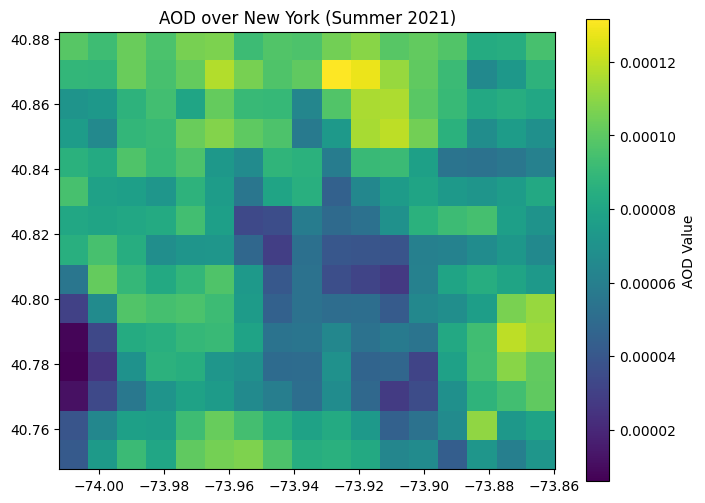

array([[9.89768285e-05, 9.25061806e-05, 1.02672372e-04, 9.58435163e-05,
        1.05591110e-04, 1.06988497e-04, 9.19800858e-05, 9.76020637e-05,
        9.65806851e-05, 1.04867694e-04, 1.09180294e-04, 9.88034307e-05,
        1.01353000e-04, 9.76025509e-05, 8.30398564e-05, 8.44187032e-05,
        9.51351458e-05],
       [8.93386363e-05, 8.84261124e-05, 1.02702590e-04, 9.49420007e-05,
        1.01628889e-04, 1.17058657e-04, 1.05752462e-04, 9.69292375e-05,
        1.01036260e-04, 1.31501840e-04, 1.27767027e-04, 1.12059039e-04,
        1.00979123e-04, 9.13068410e-05, 6.57296165e-05, 7.30506184e-05,
        8.72390650e-05],
       [7.09561507e-05, 7.28380582e-05, 8.69267227e-05, 9.37260127e-05,
        7.95589511e-05, 1.01788879e-04, 9.03845854e-05, 9.00959111e-05,
        6.36754142e-05, 9.72405093e-05, 1.15425417e-04, 1.15868466e-04,
        9.93096924e-05, 9.07310013e-05, 8.17380317e-05, 8.43735049e-05,
        8.14299002e-05],
       [7.51771905e-05, 6.50590553e-05, 8.92060531e-05, 9.037

In [58]:
# tif. file path
tif_file = "..\\data\\air_quality\\AQ_satellite_extraction\\SO2_index.tif"

# Open tif. file
with rasterio.open(tif_file) as src:
    aod_data = src.read(2)  # Đọc band đầu tiên
    profile = src.profile  # Metadata của file
    bounds = src.bounds


# print("Metadata")
# for key, value in profile.items():
#     print(f"{key}: {value}")



plt.figure(figsize=(8, 6))
plt.imshow(aod_data, cmap="viridis", interpolation="nearest", 
           extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.colorbar(label="AOD Value")
plt.title("AOD over New York (Summer 2021)")
plt.show()

aod_data

## Save Data

In [48]:
air_quality_file_path = {
    'CO': '..\\data\\air_quality\\AQ_satellite_extraction\\CO_index.tif',
    'HCHO': '..\\data\\air_quality\\AQ_satellite_extraction\\HCHO_index.tif',
    'NO2': '..\\data\\air_quality\\AQ_satellite_extraction\\NO2_index.tif',
    'O3': "..\\data\\air_quality\\AQ_satellite_extraction\\O3_index.tif",
    'SO2': '..\\data\\air_quality\\AQ_satellite_extraction\\SO2_index.tif'
}

co_bands = ['CO_column_number_density']
hcho_bands = [
    'tropospheric_HCHO_column_number_density',
    'HCHO_slant_column_number_density'
]
no2_bands = [
    'NO2_column_number_density',
    'tropospheric_NO2_column_number_density',
    'stratospheric_NO2_column_number_density',
    'NO2_slant_column_number_density'
]
o3_bands = [
    'O3_column_number_density',
    'O3_slant_column_number_density'
]
so2_bands = [
    'SO2_column_number_density',
    'SO2_slant_column_number_density'
]

all_bands = co_bands + hcho_bands + no2_bands + o3_bands + so2_bands

with rasterio.open(air_quality_file_path['CO']) as src:
    meta = src.meta.copy()
    height, width = src.shape
    transform = src.transform

# Cập nhật metadata để có tổng số bands tương ứng
meta.update(count=len(all_bands), dtype=rasterio.float64)

# Tạo tệp TIFF chứa tất cả bands
output_tif = "..\\data\\air_quality\\AQ_satellite_extraction\\Merged_air_quality.tif"
with rasterio.open(output_tif, 'w', **meta) as dst:
    band_index = 1  # Chỉ số band trong file đầu ra
    for pollutant, bands in zip(air_quality_file_path.keys(), [co_bands, hcho_bands, no2_bands, o3_bands, so2_bands]):
        with rasterio.open(air_quality_file_path[pollutant]) as src:
            for i, band_name in enumerate(bands):
                data = src.read(i + 1)  # Đọc band đầu tiên (giả sử mỗi file chỉ có 1 band)
                dst.write(data, band_index)  # Ghi vào band tương ứng
                dst.set_band_description(band_index, band_name)  # Đặt tên band
                band_index += 1

print(f"✅ Merged TIFF saved at: {output_tif}")


✅ Merged TIFF saved at: ..\data\air_quality\AQ_satellite_extraction\Merged_air_quality.tif


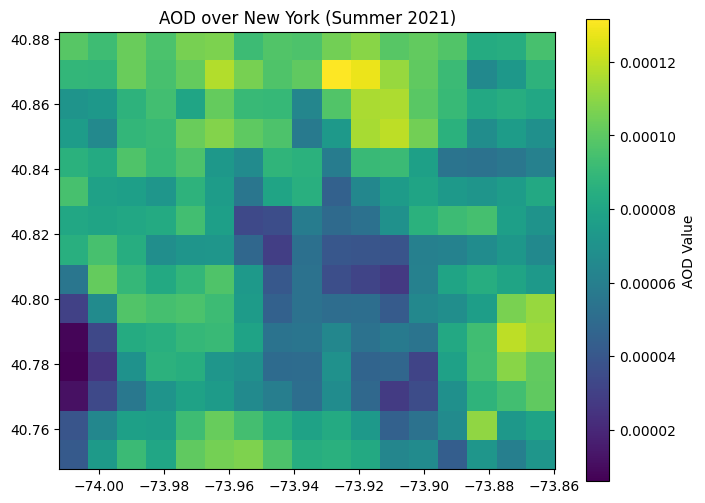

array([[9.89768285e-05, 9.25061806e-05, 1.02672372e-04, 9.58435163e-05,
        1.05591110e-04, 1.06988497e-04, 9.19800858e-05, 9.76020637e-05,
        9.65806851e-05, 1.04867694e-04, 1.09180294e-04, 9.88034307e-05,
        1.01353000e-04, 9.76025509e-05, 8.30398564e-05, 8.44187032e-05,
        9.51351458e-05],
       [8.93386363e-05, 8.84261124e-05, 1.02702590e-04, 9.49420007e-05,
        1.01628889e-04, 1.17058657e-04, 1.05752462e-04, 9.69292375e-05,
        1.01036260e-04, 1.31501840e-04, 1.27767027e-04, 1.12059039e-04,
        1.00979123e-04, 9.13068410e-05, 6.57296165e-05, 7.30506184e-05,
        8.72390650e-05],
       [7.09561507e-05, 7.28380582e-05, 8.69267227e-05, 9.37260127e-05,
        7.95589511e-05, 1.01788879e-04, 9.03845854e-05, 9.00959111e-05,
        6.36754142e-05, 9.72405093e-05, 1.15425417e-04, 1.15868466e-04,
        9.93096924e-05, 9.07310013e-05, 8.17380317e-05, 8.43735049e-05,
        8.14299002e-05],
       [7.51771905e-05, 6.50590553e-05, 8.92060531e-05, 9.037

In [60]:
# tif. file path
tif_file = "..\\data\\air_quality\\AQ_satellite_extraction\\Merged_air_quality.tif"

# Open tif. file
with rasterio.open(tif_file) as src:
    aod_data = src.read(11)  # Đọc band đầu tiên
    profile = src.profile  # Metadata của file
    bounds = src.bounds


# print("Metadata")
# for key, value in profile.items():
#     print(f"{key}: {value}")



plt.figure(figsize=(8, 6))
plt.imshow(aod_data, cmap="viridis", interpolation="nearest", 
           extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
plt.colorbar(label="AOD Value")
plt.title("AOD over New York (Summer 2021)")
plt.show()

aod_data